# Belief Propagation on tree-structured graphs

Consider a probabilistic graphical model in seven variables that has the following conditional independence property, represented as a tree:

![image](../Figures/tree_graph.png)

We assume that the variables are discrete with five possible states $x_i \in \{1, 2, 3, 4, 5\}$, and that the joint distribution of $x_1, \ldots, x_7$ decompose into pairwise potentials:
$$
p(x_1, x_2, x_3, x_4, x_5, x_6, x_7) = \psi_{12}(x_1, x_2) \psi_{23}(x_2, x_3) \psi_{24}(x_2, x_4) \psi_{35}(x_3, x_5) \psi_{46}(x_4, x_6) \psi_{47}(x_4, x_7)
$$

Our goal in this notebook is to infer the marginal probabilities $p(x_i)$ for $i = 1, \ldots, 7$ when the pairwise potential functions are given by

$$
\psi_{ij}(x_i, x_j) = \Psi,
$$

for all $i \sim j$, where $\Psi$ is a symmetric $5 \times 5$ matrix given as

$$
\Psi = 
\begin{bmatrix}
1 & 2 & 0 & 1 & 0.1 \\
2 & 3 & 0 & 0 & 0.1 \\
0 & 0 & 3 & 1 & 0.1 \\
1 & 0 & 1 & 2 & 0.1 \\
0.1 & 0.1 & 0.1 & 0.1 & 1
\end{bmatrix}.
$$
Since the graph is tree-structured, we can comfortably apply belief propagation to do the inference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
os.chdir('..')
from models import Potential, TreeGraph
from algorithms import BeliefPropagation

Before we apply belief propagation, let's first compute the marginals by brute force for comparison. The problem considered here is small enough for brute force computation to be possible.

In [2]:
# Set up potential
Psi = np.array([[1.,2.,0.,1.,0.1],
                [2.,3.,0.,0.,0.1],
                [0.,0.,3.,1.,0.1],
                [1.,0.,1.,2.,0.1],
                [0.1,0.1,0.1,0.1,1.]])

Psi12 = Psi[:,:,None,None,None,None,None]
Psi23 = Psi[None,:,:,None,None,None,None]
Psi24 = Psi[None,:,None,:,None,None,None]
Psi35 = Psi[None,None,:,None,:,None,None]
Psi46 = Psi[None,None,None,:,None,:,None]
Psi47 = Psi[None,None,None,:,None,None,:]

# Compute joint probability
joint_probability = Psi12 * Psi23 * Psi24 * Psi35 * Psi46 * Psi47 # Shape (5, 5, 5, 5, 5, 5, 5)
Z = joint_probability.sum()
joint_probability /= Z

In [3]:
# Compute marginal distributions on every node by brute force
true_marginals = []
for i in range(7):
    p_i = joint_probability
    for j in range(7):
        if j != i:
            p_i = p_i.sum(axis=j, keepdims=True)
    p_i = p_i.squeeze()
    true_marginals.append(p_i)

We plot the results obtained by brute force computation

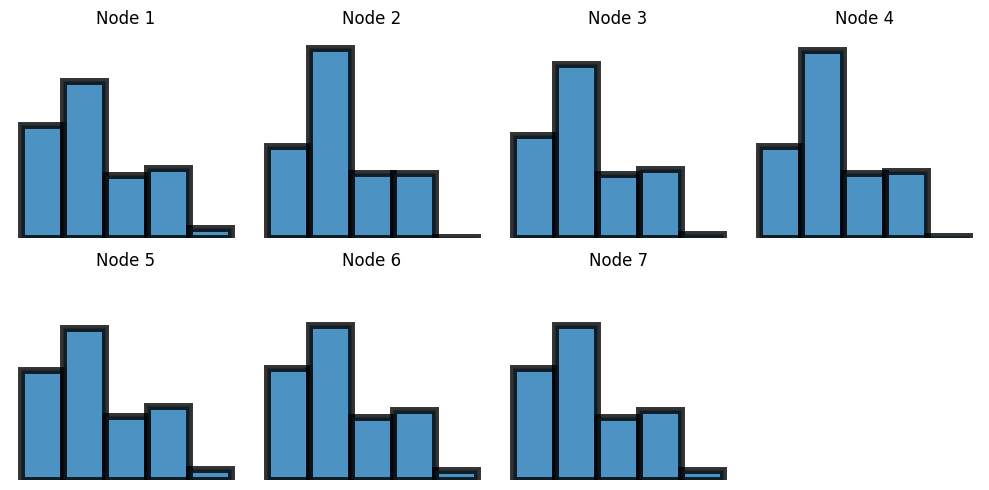

In [4]:
def plot_bar(marginals):
    fig, axs = plt.subplots(2,4, figsize=(10,5))
    for i in range(7):
        I = i // 4
        J = i % 4
        axs[I,J].bar(np.arange(5), marginals[i], width=1.0, edgecolor='black', linewidth=5, alpha=0.8)
        axs[I,J].set_title(f"Node {i+1}")
        axs[I,J].set_ylim([0,0.5])
        axs[I,J].set_axis_off()
    axs[1,3].set_axis_off()
    plt.tight_layout()

plot_bar(true_marginals)

Now, let's apply belief propagation and compare with the results obtained by brute force computation.

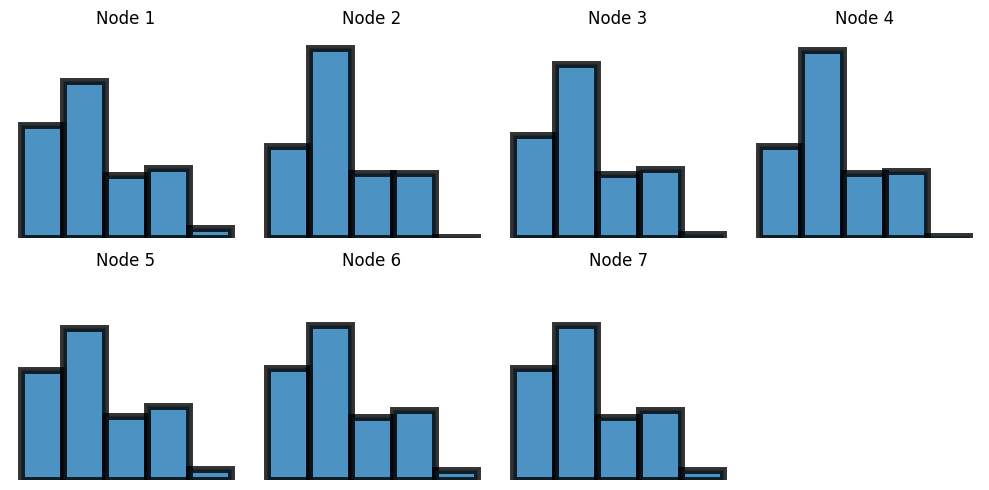

In [5]:
# Use belief propagation to compute marginals
edge_potentials = [Potential(Psi, variables=[1,2]),
                   Potential(Psi, variables=[2,3]),
                   Potential(Psi, variables=[2,4]),
                   Potential(Psi, variables=[3,5]),
                   Potential(Psi, variables=[4,6]),
                   Potential(Psi, variables=[4,7])]
                   
f = TreeGraph(edge_potentials, state_type='marginal') # Set up graphical model
BeliefPropagation(f, root_node=1) # Run belief propagation, taking node 1 as the root node
plot_bar(list(f.states.values()))

We can see that the obtained results look identical to that obtained by brute force computation! In fact, they are indeed identical (up to some tolerance level) as we expect from theory:

In [6]:
any([any(np.abs(state - true_state) < 1e-15) for state, true_state in zip(f.states.values(), true_marginals)])

True

## Computation by hand

Below, we run the belief propagation algorithm by hand to better understand its inner workings. This is essentially what is happening inside the `BeliefPropagation` function used above.

### Leaves to root
We first propagate messages from leaf nodes up to the root node, taking node 1 as the root.

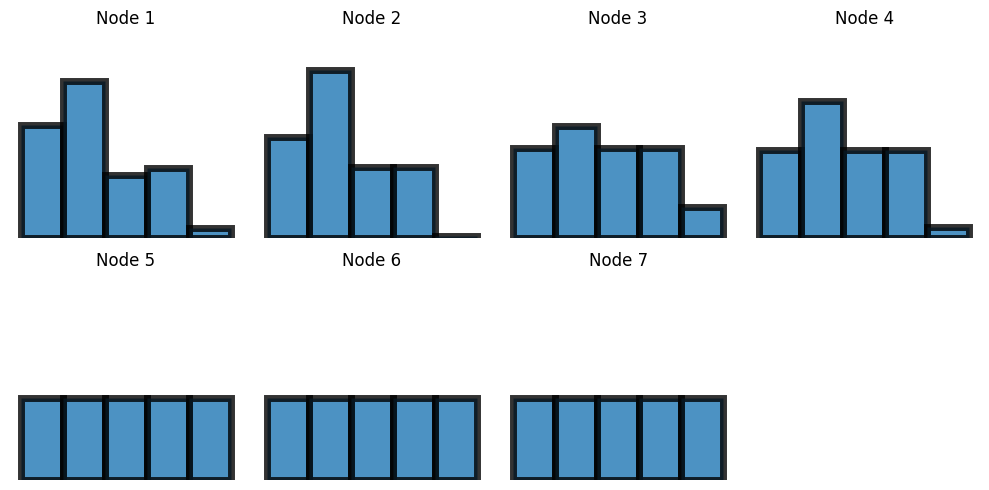

In [7]:
# Initialise states
init = [np.ones(5)/5 for _ in range(7)]
states = copy.copy(init)

##
# Propagate messages from leaf nodes to root node
##

m53 = Psi @ init[4] # Send message from node 5 to node 3
m64 = Psi @ init[5] # Send message from node 6 to node 4
m74 = Psi @ init[6] # Send message from node 7 to node 4

# Update state at node 3
p3 = states[2] * m53
p3 /= p3.sum()
states[2] = p3

# Update state at node 4
p4 = states[3] * m64 * m74
p4 /= p4.sum()
states[3] = p4

##
m32 = Psi @ m53 # Send message from node 3 to node 2
m42 = Psi @ (m64 * m74) # Send message from node 4 to node 2

# Update state at node 2
p2 = states[1] * m32 * m42
p2 /= p2.sum()
states[1] = p2

##
m21 = Psi @ (m32 * m42) # Send message from node 2 to node 1

# Update state at node 1
p1 = states[0] * m21
ZZ = p1.sum()
p1 /= p1.sum()
states[0] = p1

##
plot_bar(states)

### Root to leaves
Next, we propagate messages from the root node back to the leaf nodes to complete the algorithm.

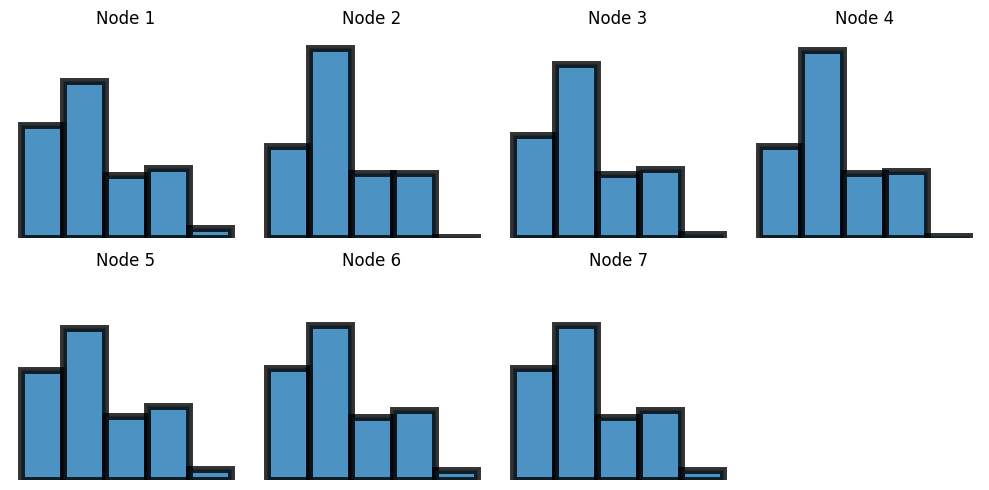

In [8]:
##
# Propagate messages from the root node back to the leaf nodes
##

m12 = Psi.T @ init[0] # Send message from node 1 to node 2

# Update state at node 2
p2 = states[1] * m12
p2 /= p2.sum()
states[1] = p2

##
m23 = Psi.T @ (m12 * m42) # Send message from node 2 to node 3
m24 = Psi.T @ (m12 * m32) # Send message from node 2 to node 4

# Update state at node 3
p3 = states[2] * m23
p3 /= p3.sum()
states[2] = p3

# Update state at node 4
p4 = states[3] * m24
p4 /= p4.sum()
states[3] = p4

##
m35 = Psi.T @ m23 # Send message from node 3 to node 5
m46 = Psi.T @ (m24 * m74) # Send message from node 4 to node 6
m47 = Psi.T @ (m24 * m64) # Send message from node 4 to node 7

# Update state at node 5
p5 = states[4] * m35
p5 /= p5.sum()
states[4] = p5

# Update state at node 6
p6 = states[5] * m46
p6 /= p6.sum()
states[5] = p6

# Update state at node 7
p7 = states[6] * m47
p7 /= p7.sum()
states[6] = p7

##
plot_bar(states)